# Train VAE Tutorial

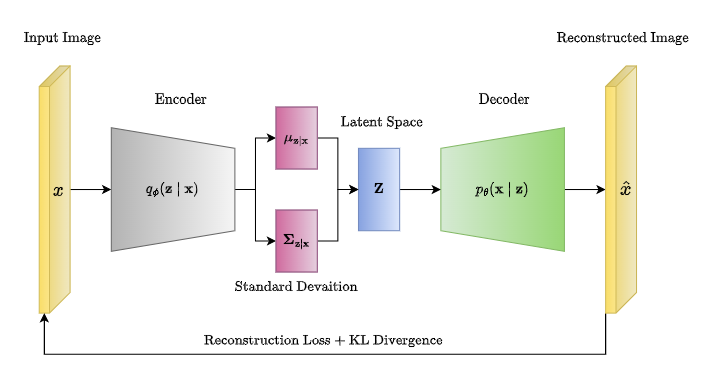

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import math
import os
import shutil
from sklearn.model_selection import train_test_split
import os


Self Attention is machanism which achieve attention in a single sequence, means it calculates attention among all the tokens within single sequence. Attention help us to pay attention with different intensity among all tokens in the sequence. Self-attention is widely used in the encoder part of the Transformer model, where the model needs to understand and encode the entire input sequence’s context.

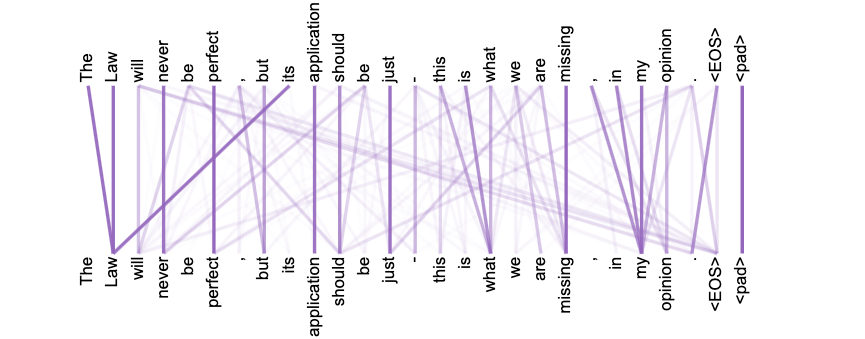

In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, n_heads, embd_dim, in_proj_bias=True, out_proj_bias=True):
    super().__init__()
    self.n_heads = n_heads
    self.in_proj = nn.Linear(embd_dim, 3 * embd_dim, bias=in_proj_bias)
    self.out_proj = nn.Linear(embd_dim, embd_dim, bias=out_proj_bias)

    self.d_heads = embd_dim // n_heads

  def forward(self, x, casual_mask=False):
    # x: (batch_size, seq_len, dim)

    batch_size, seq_len, d_emed = x.shape

    interim_shape = (batch_size, seq_len, self.n_heads, self.d_heads)

    # (batch_size, seq_len, dim) -> 3 * (batch_size, seq_len, d_embed)
    q, k, v = self.in_proj(x).chunk(3, dim=-1)

    # change the shape of q, k and v to match the interim shape
    q = q.view(interim_shape)
    k = k.view(interim_shape)
    v = v.view(interim_shape)

    # swap the elements within matrix using transpose
    # take n_heads before seq_len, like that: (batch_size, n_heads, seq_len, d_embed)
    q = q.transpose(1, 2)
    k = k.transpose(1, 2)
    v = v.transpose(1, 2)

    # calculate the attention
    weight = q @ k.transpose(-1, -2)

    if casual_mask:
        # mask where the upper traingle (above the prinicpal dagonal) is 1
        mask = torch.ones_like(weight, dtype=torch.bool).triu(1)
        # fill the upper traingle with -inf
        weight.masked_fill_(mask, -torch.inf)

    weight /= math.sqrt(self.d_heads)

    weight = F.softmax(weight, dim=-1)

    # (batch_size, h_heads, seq_len, dim / h)
    output = weight @ v

    # (batch_size, h_heads, seq_len, dim / h) -> (batch_size, seq_len, n_heads, dim / h)
    output = output.transpose(1, 2)

    # change the shape to the shape of out_proj
    output = output.reshape((batch_size, seq_len, d_emed))

    output = self.out_proj(output)

    return output






This Attention Block uses self attention using residual technique with group norms as all the features we have are pixel values and attention tries to find what are good features to pay attention in all features.

In [ ]:

class AttentionBlock(nn.Module):
  def __init__(self, channels):
      super().__init__()
      self.groupnorm = nn.GroupNorm(32, channels)
      self.attention = SelfAttention(1, channels)

  def forward(self, x):
      # x: (batch_size, channels, h, w)
      residual = x.clone()

      # (batch_size, channels, h, w) -> (batch_size, channels, h, w)
      x = self.groupnorm(x)

      n, c, h, w = x.shape

      # (batch_size, channels, h, w) -> (batch_size, channels, h * w)
      x = x.view((n, c, h * w))

      # (batch_size, channels, h * w) -> (batch_size, h * w, channels)
      x = x.transpose(-1, -2)

      # perform self-attention without mask
      # (batch_size, h * w, channels) -> (batch_size, h * w, channels)
      x = self.attention(x)

      # (batch_size, h * w, channels) -> (batch_size, channels, h * w)
      x = x.transpose(-1, -2)

      # (batch_size, channels, h * w) -> (batch_size, channels, h, w)
      x = x.view((n, c, h, w))

      # (batch_size, channels, h, w) -> (batch_size, channels, h, w)
      x += residual

      return x



This Implements ResidualBlock which we use in Encoder and Decoder

In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.groupnorm1 = nn.GroupNorm(32, in_channels)
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

    self.groupnorm2 = nn.GroupNorm(32, out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    if in_channels == out_channels:
      self.residual_layer = nn.Identity()
    else:
      self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)

  def forward(self, x):
    # x: (batch_size, in_channels, h, w)
    residue = x.clone()

    x = self.groupnorm1(x)
    x = F.selu(x)
    x = self.conv1(x)
    x = self.groupnorm2(x)
    x = self.conv2(x)

    return x + self.residual_layer(residue)

This is Encoder which help us to encode the images in latents with lower dimensions, it consist of convolutional layers to extract features, residual block to maintain and allow to build deeper networks. In the forward method we extract mean and standard divation from the output of the encoder and build the final latents 'z' with them.

In [ ]:

class Encoder(nn.Sequential):
    def  __init__(self):
        super().__init__(
            # (batch_size, channel, h, w) -> (batch_size, 128, h, w)
            nn.Conv2d(3, 128, kernel_size=3, padding=1),

            # (batch_size, 128, h, w) -> (batch_size, 128, h, w)
            ResidualBlock(128, 128),

            # (batch_size, 128, h, w) -> (batch_size, 128, h / 2, w / 2)
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=0),

            # (batch_size, 128, h / 2, w / 2) -> (batch_size, 256, h / 2, w / 2)
            ResidualBlock(128, 256),

            # (batch_size, 256, h / 2, w / 2) -> (batch_size, 256, h / 2, w / 2)
            ResidualBlock(256, 256),

            # (batch_size, 256, h / 2, w / 2) -> (batch_size, 256, h / 4, w / 4)
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=0),

            # (batch_size, 256, h / 4, w / 4) -> (batch_size, 512, h / 4, w / 4)
            ResidualBlock(256, 512),

            # (batch_size, 512, h / 4, w / 4) -> (batch_size, 512, h / 4, w / 4)
            ResidualBlock(512, 512),

            # (batch_size, 512, h / 4, w / 4) -> (batch_size, 512, h / 8, w / 8)
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=0),

            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 512, h / 8, w / 8)
            ResidualBlock(512, 512),

            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 512, h / 8, w / 8)
            ResidualBlock(512, 512),

            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 512, h / 8, w / 8)
            ResidualBlock(512, 512),

            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 512, h / 8, w / 8)
            AttentionBlock(512),

            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 512, h / 8, w / 8)
            ResidualBlock(512, 512),

            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 512, h / 8, w / 8)
            nn.GroupNorm(32, 512),

            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 512, h / 8, w / 8)
            nn.SiLU(),

            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 8, h / 8, w / 8)
            nn.Conv2d(512, 8, kernel_size=3, padding=1),

            # (batch_size, 8, h / 8, w / 8) -> (batch_size, 8, h / 8, w / 8)
            nn.Conv2d(8, 8, kernel_size=1, padding=0)
        )
    def forward(self, x):
        # x: (batch_size, channel, h, w)

        for module in self:
            if isinstance(module, nn.Conv2d) and module.stride == (2, 2):
                x = F.pad(x, (0, 1, 0, 1))  # (left, right, top, bottom)
            x = module(x)

        # (batch_size, 8, h / 8, w / 8) -> two tensors of shape (batch_size, 4, h / 8, w / 8)
        mean, log_variance = torch.chunk(x, 2, dim=1)

        # Clamp log variance between -30 and 20
        log_variance = torch.clamp(log_variance, -30, 20)

        # Reparameterization trick
        std = torch.exp(0.5 * log_variance)
        eps = torch.randn_like(std)
        x = mean + eps * std

        # Scale the latent representation
        x *= 0.18215

        return x


Decoder decode the latents to the original output, it also consist of attnetion block, residual block and Upsample layer which add features to add more dimensions to the image to turn back to original image

In [ ]:

class Decoder(nn.Sequential):
    def __init__(self):
        super().__init__(
            # (batch_size, 4, 32, 32) -> (batch_size, 512, 32, 32)
            nn.Conv2d(4, 512, kernel_size=3, padding=1),

            # (batch_size, 512, 32, 32) -> (batch_size, 512, 32, 32)
            ResidualBlock(512, 512),

            # (batch_Size, 512, 32, 32) -> (batch_size, 512, 32, 32)
            AttentionBlock(512),

            # (batch_size, 512, 32, 32) -> (batch_size, 512, 32, 32)
            ResidualBlock(512, 512),

            # (batch_size, 512, 32, 32) -> (batch_size, 512, 32, 32)
            ResidualBlock(512, 512),

            # (batch_size, 512, 32, 32) -> (batch_size, 512, 32, 32)
            ResidualBlock(512, 512),

            # (batch_size, 512, 32, 32) -> (batch_size, 512, 64, 64)
            nn.Upsample(scale_factor=2),

            # (batch_size, 512, 64, 64) -> (batch_size, 512, 64, 64)
            nn.Conv2d(512, 512, kernel_size=3, padding=1),

            # (batch_size, 512, 64, 64) -> (batch_size, 512, 64, 64)
            ResidualBlock(512, 512),

            # (batch_size, 512, 64, 64) -> (batch_size, 512, 64, 64)
            ResidualBlock(512, 512),

            # (batch_size, 512, 64, 64) -> (batch_size, 512, 64, 64)
            ResidualBlock(512, 512),

            # (batch_size, 512, 64, 64) -> (batch_size, 512, 128, 128)
            nn.Upsample(scale_factor=2),

            # (batch_size, 512, 128, 128) -> (batch_size, 512, 128, 128)
            nn.Conv2d(512, 512, kernel_size=3, padding=1),

            # (batch_size, 512, 128, 128) -> (batch_size, 256, 128, 128)
            ResidualBlock(512, 256),

            # (batch_size, 256, 128, 128) -> (batch_size, 256, 128, 128)
            ResidualBlock(256, 256),

            # (batch_size, 256, 128, 128) -> (batch_size, 256, 128, 128)
            ResidualBlock(256, 256),

            # (batch_size, 256, 128, 128) -> (batch_size, 256, 256, 256)
            nn.Upsample(scale_factor=2),

            # (batch_size, 256, 256, 256) -> (batch_size, 256, 256, 256)
            nn.Conv2d(256, 256, kernel_size=3, padding=1),

            # (batch_size, 256, 256, 256) -> (batch_size, 128, 256, 256)
            ResidualBlock(256, 128),

            # (batch_size, 128, 256, 256) -> (batch_size, 128, 256, 256)
            ResidualBlock(128, 128),

            # (batch_size, 128, 256, 256) -> (batch_size, 128, 256, 256)
            ResidualBlock(128, 128),

            nn.GroupNorm(32, 128),

            nn.SiLU(),

            # (batch_size, 128, 256, 256) -> (batch_size, 3, 256, 256)
            nn.Conv2d(128, 3, kernel_size=3, padding=1),
        )
    def forward(self, x):
        # x: (batch_size, 4, h / 8, w / 8)

        # remove the scaling adding by the encoder
        x /= 0.18215

        for module in self:
            x = module(x)

        # (batch_size, 3, h, w)
        return x

# Download & Process the Dataset

In [ ]:
!gdown 1KXRTB_q4uub_XOHecpsQjE4Kmv76sZbV

Downloading...
From (original): https://drive.google.com/uc?id=1KXRTB_q4uub_XOHecpsQjE4Kmv76sZbV
From (redirected): https://drive.google.com/uc?id=1KXRTB_q4uub_XOHecpsQjE4Kmv76sZbV&confirm=t&uuid=7364eaf9-d28a-4ada-bff6-7997d3e7d6b2
To: /content/all-dogs.zip
100% 775M/775M [00:17<00:00, 45.3MB/s]


In [ ]:
!unzip all-dogs.zip

Streaming output truncated to the last 5000 lines.
  inflating: all-dogs/n02113624_8890.jpg  
  inflating: all-dogs/n02107683_215.jpg  
  inflating: all-dogs/n02093428_5326.jpg  
  inflating: all-dogs/n02105412_8018.jpg  
  inflating: all-dogs/n02093647_3129.jpg  
  inflating: all-dogs/n02088466_8078.jpg  
  inflating: all-dogs/n02108915_4214.jpg  
  inflating: all-dogs/n02089078_2841.jpg  
  inflating: all-dogs/n02105855_3498.jpg  
  inflating: all-dogs/n02094114_2823.jpg  
  inflating: all-dogs/n02088094_649.jpg  
  inflating: all-dogs/n02091831_2232.jpg  
  inflating: all-dogs/n02096585_3105.jpg  
  inflating: all-dogs/n02109961_977.jpg  
  inflating: all-dogs/n02097047_5869.jpg  
  inflating: all-dogs/n02106030_16250.jpg  
  inflating: all-dogs/n02110958_13721.jpg  
  inflating: all-dogs/n02107142_8437.jpg  
  inflating: all-dogs/n02094433_1312.jpg  
  inflating: all-dogs/n02097474_5481.jpg  
  inflating: all-dogs/n02097130_1531.jpg  
  inflating: all-dogs/n02092339_284.jpg  
  inf

In [ ]:
def split_dataset(source_dir, train_dir, test_dir, test_size=0.2, random_state=42):
    image_files = [f for f in os.listdir(source_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    train_files, test_files = train_test_split(image_files, test_size=test_size, random_state=random_state)

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for file in train_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(train_dir, file))

    for file in test_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(test_dir, file))

    print(f"Dataset split complete. {len(train_files)} training images, {len(test_files)} test images.")

source_dir = "./all-dogs"
train_dir = "./data/train/dogs"
test_dir = "./data/test/dogs"

split_dataset(source_dir, train_dir, test_dir)

Dataset split complete. 16463 training images, 4116 test images.


# Implement VAE

In [ ]:
# Model
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

# Train The VAE

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
# from model import Encoder, Decoder

# Device configuration
device = torch.device('cuda')

# Hyperparameters
num_epochs = 100
learning_rate = 1e-4
beta = 0.00025  # KL divergence weight

# Data loading
transform = transforms.Compose([
    transforms.Resize((56, 56)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
batch_size = 4
dataset = torchvision.datasets.ImageFolder(root='./data/train', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Add these hyperparameters
accumulation_steps = 1  # Adjust as needed
effective_batch_size = batch_size * accumulation_steps

train_losses = []

# training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for i, (images, _) in enumerate(dataloader):
        images = images.to(device)

        # Forward pass
        reconstructed, encoded = model(images)

        # Compute loss
        recon_loss = nn.MSELoss()(reconstructed, images)

        # Extract mean and log_variance from encoded
        mean, log_variance = torch.chunk(encoded, 2, dim=1)

        kl_div = -0.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp())
        loss = recon_loss + beta * kl_div

        # Normalize the loss to account for accumulation
        loss = loss / accumulation_steps

        # Backward pass
        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        train_loss += loss.item() * accumulation_steps

        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], '
              f'Loss: {loss.item()*accumulation_steps:.4f}, Recon Loss: {recon_loss.item():.4f}, KL Div: {kl_div.item():.4f}')



        with torch.no_grad():
            # Take the first image from the batch
            sample_image = images[0].unsqueeze(0)
            sample_reconstructed = model(sample_image)[0]

            sample_image = (sample_image * 0.5) + 0.5
            sample_reconstructed = (sample_reconstructed * 0.5) + 0.5

            torchvision.utils.save_image(sample_reconstructed, 'reconstructed.png')

    train_losses.append(train_loss / len(dataloader))
  # Save the model checkpoint
    torch.save(model.state_dict(), f'vae_model_epoch_{epoch+1}.pth')

print('Training finished!')

In [ ]:
import matplotlib.pyplot as plt

# plot the loss curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Loss over Time')
plt.legend()
plt.show()